### Dataset Information

The dataset contains sonar signals used to distinguish between metal cylinders (mines) and rocks. There are 111 patterns from metal cylinders and 97 from rocks, collected under various conditions and angles. Each pattern includes 60 numbers representing the energy in specific frequency bands, with higher frequencies occurring later. The labels are "R" for rocks and "M" for mines. This dataset, which has no missing values, is used for machine learning tasks. For more details, visit [Connectionist Bench (Sonar, Mines vs. Rocks). UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/151/connectionist+bench+sonar+mines+vs+rocks)

### Imports 

In [1]:
import matplotlib as mpl

font = {'family' : 'Georgia',
        'weight' : 'bold',
        'size'   : 12}

COLOR = 'gray'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

mpl.rc('font', **font)

import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

# Metrics
from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Classifiers
from sklearn.preprocessing import RobustScaler, MaxAbsScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.naive_bayes import GaussianNB


### Importing the Dataset

In [2]:
# Load the dataset
data = pd.read_csv('sonar.all-data-uci.csv')
data.head(5)


,Freq_1,Freq_2,Freq_3,Freq_4,Freq_5,Freq_6,Freq_7,Freq_8,Freq_9,Freq_10,...,Freq_52,Freq_53,Freq_54,Freq_55,Freq_56,Freq_57,Freq_58,Freq_59,Freq_60,Label
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


### Splitting the data into training and testing sets

In [3]:
# Assign feature columns and target column
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

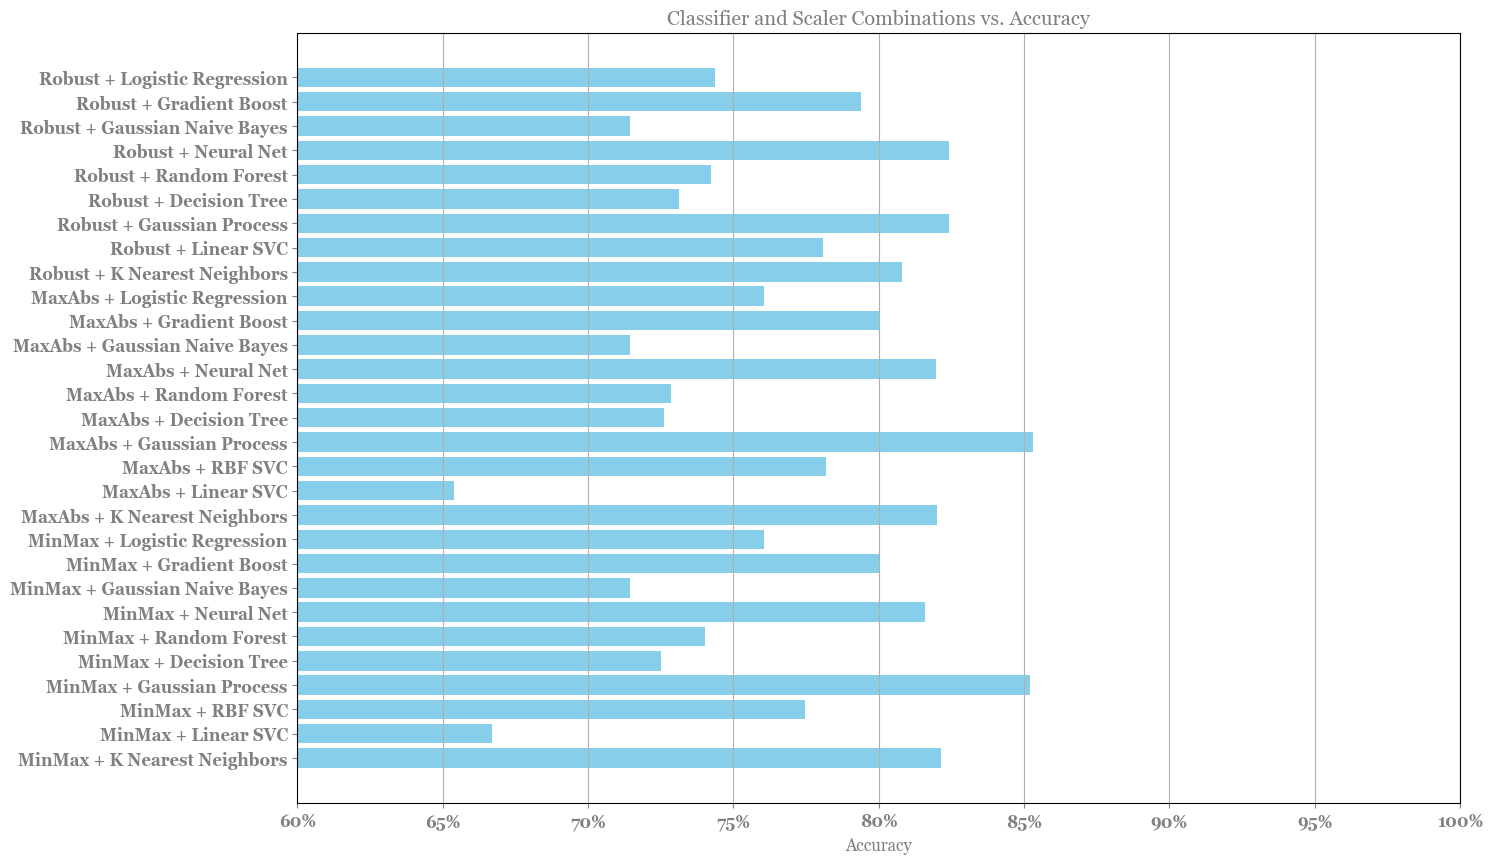

In [4]:
def cross_validation(classifiers, classifier_names, scalers, scaler_names, X, y):
    results = {}
    for scaler, scaler_name in zip(scalers, scaler_names):
        X_scaled = scaler.fit_transform(X)
        train_x, test_x, train_y, test_y = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

        for clf, clf_name in zip(classifiers, classifier_names):
            clf.fit(train_x, train_y)
            y_pred = clf.predict(test_x)
            score = accuracy_score(test_y, y_pred)
            # print(f"Scaler: {scaler_name}, Classifier: {clf_name}, Accuracy: {score:.2f}")

            cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
            cv_scores = cross_val_score(clf, X_scaled, y, scoring='accuracy', cv=cv, n_jobs=-1)
            results[(scaler_name, clf_name)] = cv_scores

    return results

# Define scalers and classifiers
scaler_names = ['MinMax', 'MaxAbs', 'Robust']
scalers = [MinMaxScaler(), MaxAbsScaler(), RobustScaler()]

classifier_names = [
    "K Nearest Neighbors", 
    "Linear SVC", 
    "RBF SVC", 
    "Gaussian Process",
    "Decision Tree", 
    "Random Forest", 
    "Neural Net",
    "Gaussian Naive Bayes", 
    "Gradient Boost", 
    "Logistic Regression"
]

classifiers = [
    KNeighborsClassifier(3), 
    SVC(kernel="linear", C=0.025), 
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)), 
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000), 
    GaussianNB(), 
    GradientBoostingClassifier(), 
    LogisticRegression()
]


# Perform cross-validation
results = cross_validation(classifiers, classifier_names, scalers, scaler_names, X_train, y_train)

# Convert results to a DataFrame
data = []
for (scaler_name, clf_name), scores in results.items():
    mean_accuracy = np.mean(scores)
    data.append((scaler_name, clf_name, mean_accuracy))

df = pd.DataFrame(data, columns=['Scaler', 'Classifier', 'Accuracy'])
df['Combination'] = df['Scaler'] + ' + ' + df['Classifier']

# Filter out combinations with accuracy below 50% since they are worse than taking a random guess 
df_filtered = df[df['Accuracy'] >= 0.50]

# Plot the results
plt.figure(figsize=(15, 10))
plt.barh(df_filtered['Combination'], df_filtered['Accuracy'], color='skyblue')
plt.xlabel('Accuracy')
plt.title('Classifier and Scaler Combinations vs. Accuracy')
plt.xlim(0.60, 1.0)  # Set x-axis to start at 60%
plt.grid(axis='x')
plt.xticks(ticks=np.arange(0.60, 1.01, 0.05), labels=[f'{int(x * 100)}%' for x in np.arange(0.60, 1.01, 0.05)])
plt.show()

It's clear from the chart that Gaussian Process is the strongest classifier and for scalers MaxAbs slightly outperforms MinMax. So we will continue with MaxAbs and Gaussian Process. 

In [5]:


# Standardize the feature values using Robust Scaler
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the expanded parameter grid
param_grid = {
    'kernel': [
        1.0 * RBF(length_scale) for length_scale in [0.1, 1.0, 10.0]
    ] + [
        C(1.0, (1e-2, 1e2)) * RBF(length_scale, (1e-2, 1e2)) for length_scale in [0.1, 1.0, 10.0]
    ],
    'n_restarts_optimizer': [0, 1, 2, 3],
    'max_iter_predict': [100, 200, 300, 400],
    'multi_class': ['one_vs_rest', 'one_vs_one'],
    'optimizer': ['fmin_l_bfgs_b', None],
    'n_jobs': [-1]  # Use all available cores
}

# Initialize the classifier
gpc = GaussianProcessClassifier()

# Set up the grid search
grid_search = GridSearchCV(estimator=gpc, param_grid=param_grid, cv=10, scoring='accuracy', n_jobs=-1)

# Perform the grid search on the training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Train the classifier with the best parameters
best_gpc = grid_search.best_estimator_
best_gpc.fit(X_train_scaled, y_train)

# Evaluate the best model on the test set
y_pred_best_gpc = best_gpc.predict(X_test_scaled)
accuracy_best_gpc = accuracy_score(y_test, y_pred_best_gpc)

# Generate the classification report
report_dict = classification_report(y_test, y_pred_best_gpc, output_dict=True)

# Convert the classification report to a DataFrame
report_df = pd.DataFrame(report_dict).transpose()

print("Best Gaussian Process Classifier")
print(f"Accuracy: {accuracy_best_gpc:.2f}")

report_df

Best parameters found:  {'kernel': 1**2 * RBF(length_scale=0.1), 'max_iter_predict': 100, 'multi_class': 'one_vs_rest', 'n_jobs': -1, 'n_restarts_optimizer': 0, 'optimizer': None}
Best Gaussian Process Classifier
Accuracy: 0.95


,precision,recall,f1-score,support
M,1.000000,0.923077,0.960000,26.000000
R,0.888889,1.000000,0.941176,16.000000
accuracy,0.952381,0.952381,0.952381,0.952381
macro avg,0.944444,0.961538,0.950588,42.000000
weighted avg,0.957672,0.952381,0.952829,42.000000
